# Analysis on Home Court Advantage in the English Premier League  
<hr>

# Executive Summary

This report analyses match data from all games played in the English Premier League from year 2009 to 2019. The goal of this analysis is to quantify and provide evidence for/against the existence of __Home Court Advantage__. More specifically, we will be looking at the trends in the number of goals scored by the home team, difference in the number of fouls comitted by the home and away team as well as the distance travelled by the away team. Various visualisation and data aggregation techniques will be used as part of our deep dive into this topic. 

Following which, we will conclude the report with a summary of the analysis and propose ideas on how teams should approach Home Court Advantage. Recommendations will also be made with the main aim of helping teams and coaches improve their game plan with the ultimate aim of winning more games.

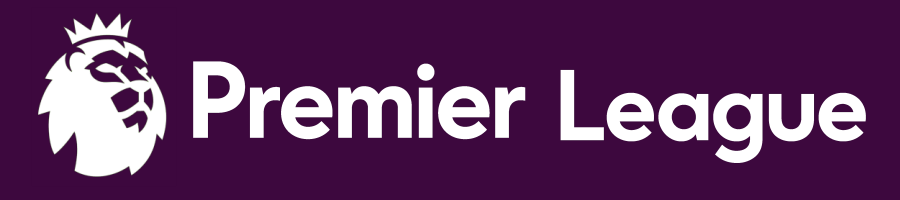

In [1]:
# importing libraries and reading dataset
import pandas as pd
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.1f}'.format
%matplotlib inline
from IPython.display import Image
epl_df = pd.read_csv('epl-season-0919.csv') # collected by http://www.football-data.co.uk
DIMS=(16,6)
display(Image('https://melaman2.com/premierleague/images/epl-top-banner_new.png', width=900, height = 200, unconfined=True))

# Introduction
In football, fans are commonly known as the "12th player". Playing in a stadium filled with cheering fans is supposed to give the home team a surge of confidence and intensity; while the hostility from the crowd puts the visiting team at a disadvantageous spot. To make matters worse, travelling long hours into unfamiliar territory may also have a detrimental effect on the players' fatigue and comfort levels. This idea of home court advantage is a term that is commonly known - and accepted - among athletes and fans alike. However, for such a seemingly obvious idea, how much do we truly understand it? 

# Problem Statement and Data Selected
For a sport like football where one goal often makes the difference between winning and losing, football organisations aim to gather all sorts of competitive advantages that they can get. With the advancement in various analytical techniques and tools, it is now commonplace to find a data scientist amongst the coaching staff. The data scientist enables the team to gain hidden insights into their match data which is readily available. An example of such a hidden insight is the true impact that Home Court Advantage has on the match result. 

There are some common theories about Home Court Advantage: 

**1)** The home team scores more goals.

**2)** The away team will commit more fouls as the referee has an inclination to favour the home team.

**3)** The away team is at a disadvantage because they have to travel long distances to the match location.

To prove the theories, I will be conducting a trend analysis on the match data of fixtures in the English Premier League from the year 2009 to 2019. The dataset is collected by http://www.football-data.co.uk/ website and contains various key statistics such as the number of goals scored by both teams, the number of corner kicks awarded to each team and the number of fouls committed etc. Prior to the analysis, basic data cleansing was performed to input meaningful column headers. Moreover, as each season's data was previously collected on separate files, I compiled the data of all 11 seasons into one CSV file.

# Data Preparation

We can first take a look at the first few rows of the dataset.

In [2]:
epl_df.head()

,Date,HomeTeam,AwayTeam,FullTimeHomeGoal,FullTimeAwayGoal,FullTimeResults,HalfTimeHomeGoal,HalfTimeAwayGoal,HalfTimeResults,Referee,...,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamFoulsCommitted,AwayTeamFoulsCommitted,HomeTeamCorners,AwayTeamCorners,HomeTeamYellow,AwayTeamYellow,HomeTeamRed,AwayTeamRed
0,15-08-09,Aston Villa,Wigan,0,2,A,0,1,A,M Clattenburg,...,5,7,15,14,4,6,2,2,0,0
1,15-08-09,Blackburn,Man City,0,2,A,0,1,A,M Dean,...,9,5,12,9,5,4,2,1,0,0
2,15-08-09,Bolton,Sunderland,0,1,A,0,1,A,A Marriner,...,3,13,16,10,4,7,2,1,0,0
3,15-08-09,Chelsea,Hull,2,1,H,1,1,D,A Wiley,...,12,3,13,15,12,4,1,2,0,0
4,15-08-09,Everton,Arsenal,1,6,A,0,3,A,M Halsey,...,5,9,11,13,4,9,0,0,0,0


The large dataset contains 22 game statistics but not all are useful for the analysis, such as 'Half Time Results'. Furthermore, some degree of correlation may exist between certain statistics. We investigate one such example on the number of shots on target, which will be affected by the number of shots taken.

In [3]:
round(epl_df['HomeTeamShots'].corr(epl_df['HomeTeamShotsOnTarget']),1)

0.7

The Pearson's Correlation coefficient between 'HomeTeamShots' and 'HomeTeamShotsOnTarget' is 0.7. Hence, we can conclude that there is a relatively strong linear relationship between the two variable. As such, we will remove one of the columns from the dataset. We will also remove other highly correlated columns as well as some columns that do not value add to the analysis.

In [4]:
epl_df_cleaned = epl_df.copy()
epl_df_cleaned = epl_df_cleaned.drop(columns = ['Date','HalfTimeHomeGoal', 'HalfTimeAwayGoal', 'HalfTimeResults',
                                               'HomeTeamShots', 'AwayTeamShots', 'HomeTeamRed', 'AwayTeamRed', 'Referee',
                                                'HomeTeamCorners','AwayTeamCorners','HomeTeamYellow','AwayTeamYellow'])
epl_df_cleaned.head()

,HomeTeam,AwayTeam,FullTimeHomeGoal,FullTimeAwayGoal,FullTimeResults,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamFoulsCommitted,AwayTeamFoulsCommitted
0,Aston Villa,Wigan,0,2,A,5,7,15,14
1,Blackburn,Man City,0,2,A,9,5,12,9
2,Bolton,Sunderland,0,1,A,3,13,16,10
3,Chelsea,Hull,2,1,H,12,3,13,15
4,Everton,Arsenal,1,6,A,5,9,11,13


Next, I also checked for the possibility of having a null value in the dataset. There are multiple reasons as to why there may be a null value. Some reasons include possible programming error or failure by the user during the data input phase or data exportation phase. These null values do not add value to the analysis and a large number of nulls may potentially even skew the analysis towards a wrong outcome. Therefore, I've conducted a check and conclude that there are **no** null values in this dataset.

In [5]:
epl_df_cleaned.isnull().values.any()

False

# Data Exploration

We will now look at a statistical summary of the dataframe.

In [6]:
epl_df_cleaned.describe()

,FullTimeHomeGoal,FullTimeAwayGoal,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamFoulsCommitted,AwayTeamFoulsCommitted
count,"3,800.0","3,800.0","3,800.0","3,800.0","3,800.0","3,800.0"
mean,1.6,1.2,6.0,4.8,10.6,11.1
std,1.3,1.2,3.4,2.9,3.4,3.6
min,0.0,0.0,0.0,0.0,0.0,1.0
25%,1.0,0.0,3.0,3.0,8.0,9.0
50%,1.0,1.0,5.0,4.0,11.0,11.0
75%,2.0,2.0,8.0,6.0,13.0,13.0
max,9.0,7.0,24.0,20.0,24.0,26.0


Looking at the mean of the columns in the dataframe, my first impression is that the home teams have been performing better statistically. For example, on average, the home team has been scoring more goals (1.6) than the away team (1.2). Also, the home team is committing lesser fouls (10.6) than the away team (11.1). Therefore, on hindsight, the statistics seem to be supporting the hypothesis that the **Home Court Advantage is legitimate**.

## Insights

### Team Offense - Average Scoring Margin

Firstly, to measure the advantage in team offence when a team is on home court, we will look at the difference in average scoring margin of the home team and the away team for each team.

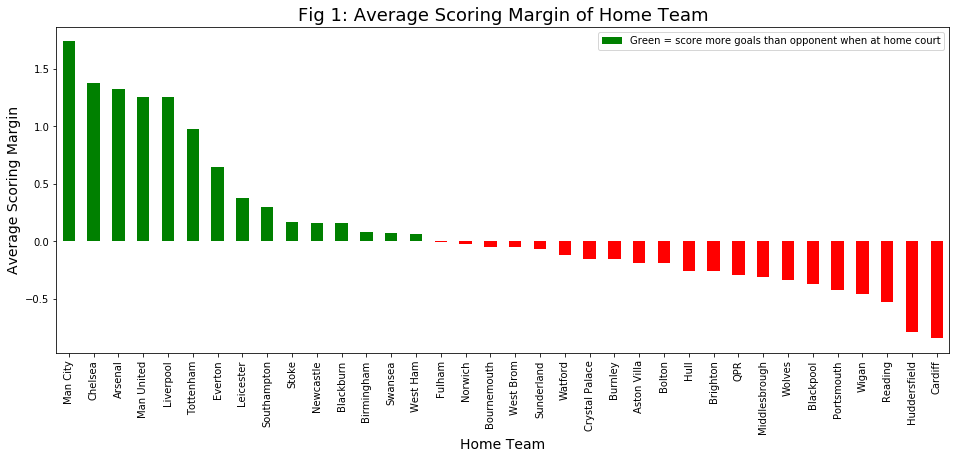

Total number of unique teams is 36:
     
Number of 'green' teams is 15 while number of 'red' teams is 21.


In [7]:
# Goal Difference equals to number of home goals minus number of away goals
epl_df_cleaned['Goal Difference'] = epl_df_cleaned['FullTimeHomeGoal'] - epl_df_cleaned['FullTimeAwayGoal']
epl_scoring_margin = epl_df_cleaned.groupby(['HomeTeam']).agg({'Goal Difference': ['sum','size']})
epl_scoring_margin = epl_scoring_margin.reset_index()
epl_scoring_margin.columns = epl_scoring_margin.columns.droplevel(level=0)

# Scoring Margin is the average difference between the number of goals scored by the home and away team 
# Positive Scoring Margin = home team scores more than away team
epl_scoring_margin['Average Scoring Margin'] = epl_scoring_margin['sum']/epl_scoring_margin['size']
results_goal = epl_scoring_margin.sort_values(['Average Scoring Margin'], ascending = False)

# Plot bar chart 
fig, ax = plt.subplots() 
clrs = []
for i in list(results_goal['Average Scoring Margin']):
    if round(i,1) <= 0:
        clrs.append('red')
    else:
        clrs.append('green')
results_goal.plot(x='', y = "Average Scoring Margin", kind='bar',ax=ax, figsize=DIMS, color=clrs)
ax.set_title('Fig 1: Average Scoring Margin of Home Team', fontsize = 18)
ax.set_ylabel('Average Scoring Margin', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)
ax.legend(['Green = score more goals than opponent when at home court'])
ax.grid(False)
plt.show()

# how many teams score more goals on average at home and win the game?
counter = 0
for i in clrs:
    if i == 'green':
        counter += 1
print("Total number of unique teams is " + str(len(clrs)) + ':')
print("     ")
print("Number of 'green' teams is " +str(counter) + " while number of 'red' teams is " + str(len(clrs)-counter)+'.')

From Fig 1, we can identify the top teams that are most likely to score more goal than their opponents at home, namely Man City, Chelsea and Arsenal. Interestingly, there are lesser teams with a positive average scoring margin than teams with a negative average scoring margin - 15 vs 21. This means that for these 21 teams, even when at home court, they tend to score fewer goals than their opponents and therefore lose the match. 

### Referee Bias - Average Foul Margin vs Home Win Rate

Next, we can determine referee bias towards the home team by analysing the difference in the number of fouls called between the home team and away team as well as how the match outcome will be impacted.

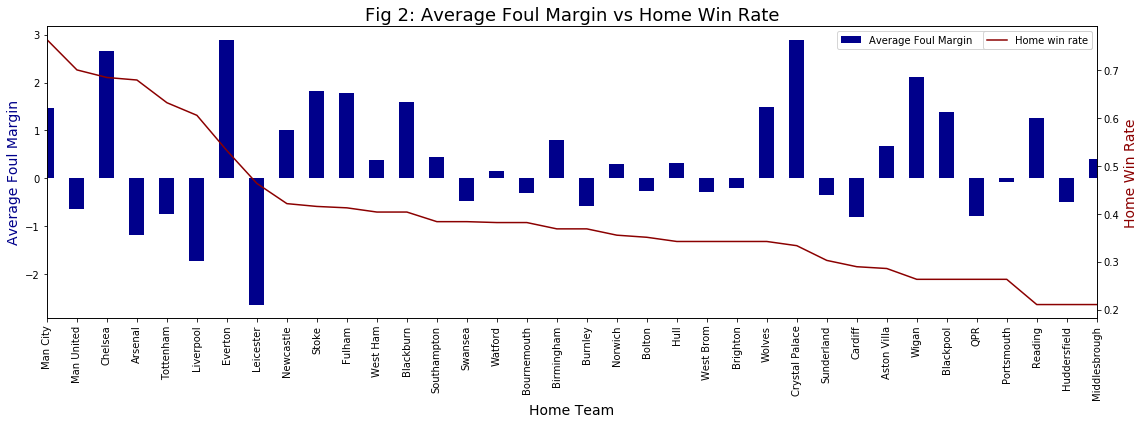

In [8]:
# Foul Difference equals to number of Fouls committed by home team minus number of Fouls committed by away team
epl_df_cleaned['Foul Difference'] = epl_df_cleaned['AwayTeamFoulsCommitted'] - epl_df_cleaned['HomeTeamFoulsCommitted']
epl_foul_margin = epl_df_cleaned.groupby(['HomeTeam']).agg({'Foul Difference': ['sum','size']})
epl_foul_margin = epl_foul_margin.reset_index()
epl_foul_margin.columns = epl_foul_margin.columns.droplevel(level=0)

# Foul Margin is the average difference of fouls committed by the home and away team
# The higher the Foul Margin, the higher the number of away fouls committed than home fouls
epl_foul_margin['Average Foul Margin'] = epl_foul_margin['sum']/epl_scoring_margin['size']

# Calculate the win rate of each team
win_rate = epl_df_cleaned.copy()
winrate_agg = win_rate.groupby(['HomeTeam', 'FullTimeResults']).size().reset_index(name="No. of teams")
winrate_pivot = pd.pivot_table(winrate_agg, index=['HomeTeam'], columns=['FullTimeResults'],
                                        values='No. of teams', aggfunc=np.sum)
winrate_pivot = winrate_pivot.reset_index()
winrate_pivot['Home Win Rate'] = winrate_pivot['H'] / (winrate_pivot['H'] + winrate_pivot['A'] + winrate_pivot['D'])
winrate_pivot = winrate_pivot.sort_values(['Home Win Rate'], ascending = False)

# Plot bar chart showing average foul margin
fig, ax = plt.subplots()
epl_foul_margin.plot(x='', y = "Average Foul Margin", kind='bar',ax=ax, figsize=DIMS, color='darkblue', rot = 90)
ax.set_title('Fig 2: Average Foul Margin vs Home Win Rate', fontsize = 18)
ax.set_ylabel('Average Foul Margin', color ='darkblue', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)

# Plot line graph showing home win rate on the same plot
ax2 = ax.twinx()
clrs2 = []
winrate_pivot.plot(x='HomeTeam',y = "Home Win Rate", kind='line',ax=ax2, figsize=DIMS, color='darkred')
ax2.set_ylabel('Home Win Rate', color = 'darkred', fontsize = 14)
ax.legend(['Average Foul Margin                                     '])
ax2.legend(['Home win rate'])
#ax.grid(False)
ax2.grid(False)
fig.tight_layout()
plt.show()

In Fig 2, the line graph represents a team's win rate when at home and the bar chart represents the average foul margin. The foul margin equals to the number of fouls committed by the away team minus that of the home team. Essentially, the higher the foul margin, the lesser the number of fouls committed by the home team compared to the away team. 

Surprisingly, there is little to no relationship between home win rates and the number of fouls called against them. **Crystal Palace**, as the home team, has the lowest number of fouls committed but yet, they have a subpar win rate of about 35%. On the other hand, **Leicester** commits the most fouls but still achieves a commendable home win rate of about 48%. Also, amongst the top 5 teams, 3 commits more fouls than their opponents (Man United, Arsenal and Tottenham). Therefore, this shows that there is little link between the number of fouls committed by the home team and their win rates.

### Distance of travel by away team to the home team

Lastly, we can investigate whether the distance between teams will affect the results of the match. According to the theory of Home Court Advantage, the further the Away team has to travel, the more fatigue they will feel and hence, the less likely they are to perform well. Therefore, we will be analysing how distance will affect the full time results.

In [9]:
# merge files twice, once to capture HomeTeam info, once to capture AwayTeam info
data_for_map = pd.read_csv('data-for-map.csv') # borough data from wikipedia.org, distance data from http://boulter.com/gps/distance/
data_for_map.columns = ['HomeTeam', 'Home Borough', 'Home Latitude', 'Home Longitude']
df_cd = pd.merge(epl_df_cleaned, data_for_map, how='outer', on = 'HomeTeam')
data_for_map.columns = ['AwayTeam', 'Away Borough','Away Latitude', 'Away Longitude']
df_cd = pd.merge(df_cd, data_for_map, how='outer', on = 'AwayTeam')
df_cd.reset_index()

# calculate distance between two coordinates (Away to Home)
Lat1 = np.radians(df_cd['Away Latitude'])
Lat2 = np.radians(df_cd['Home Latitude'])
Long1 = np.radians(df_cd['Away Longitude'])
Long2 = np.radians(df_cd['Home Longitude'])
dlon = Long2 - Long1
dlat = Lat2 - Lat1
a = np.sin(dlat / 2)**2 + np.cos(Lat1) * np.cos(Lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
distance = 6373.0 * c #6373 is the approximate radius of the Earth in km

df_cd['Distance between H and A (in km)'] = distance
display(df_cd.head())

,HomeTeam,AwayTeam,FullTimeHomeGoal,FullTimeAwayGoal,FullTimeResults,HomeTeamShotsOnTarget,AwayTeamShotsOnTarget,HomeTeamFoulsCommitted,AwayTeamFoulsCommitted,Goal Difference,Foul Difference,Home Borough,Home Latitude,Home Longitude,Away Borough,Away Latitude,Away Longitude,Distance between H and A (in km)
0,Aston Villa,Wigan,0,2,A,5,7,15,14,-2,-1,Birmingham,52.5,-1.9,Wigan,53.5,-2.6,128.5
1,Aston Villa,Wigan,1,1,D,7,4,6,11,0,5,Birmingham,52.5,-1.9,Wigan,53.5,-2.6,128.5
2,Aston Villa,Wigan,2,0,H,10,9,12,6,2,-6,Birmingham,52.5,-1.9,Wigan,53.5,-2.6,128.5
3,Aston Villa,Wigan,0,3,A,4,6,16,8,-3,-8,Birmingham,52.5,-1.9,Wigan,53.5,-2.6,128.5
4,Blackburn,Wigan,2,1,H,7,8,20,13,1,-7,Blackburn,53.7,-2.5,Wigan,53.5,-2.6,24.7


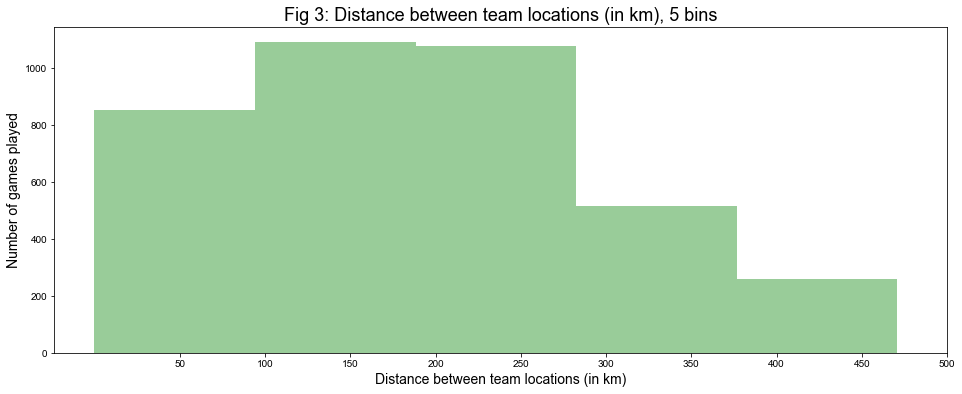

In [10]:
# plot histogram
fig = plt.figure(figsize=DIMS)
ax1 = fig.add_subplot(111)
sns.distplot(df_cd['Distance between H and A (in km)'], kde=False, ax=ax1, bins=5, color='green') 
ax1.set_title("Fig 3: Distance between team locations (in km), 5 bins", fontsize=18)
ax1.set_ylabel("Number of games played", fontsize = 14)
ax1.set_xlabel("Distance between team locations (in km)", fontsize = 14)
ax1.set_xticks([50,100,150,200,250,300,350,400,450,500])
sns.set_style("darkgrid",{'grid.color': '0.7'})

plt.show()

From the histogram, we can tell that most away teams typically need to travel between 100 - 200km to their destination. On average, the away team will travel 187km before their games. Assuming most teams travel by coach and the average speed limit for coaches on UK's highway is 80km/h, the away team will spend approximately 2h 20mins on the road before reaching their destination.

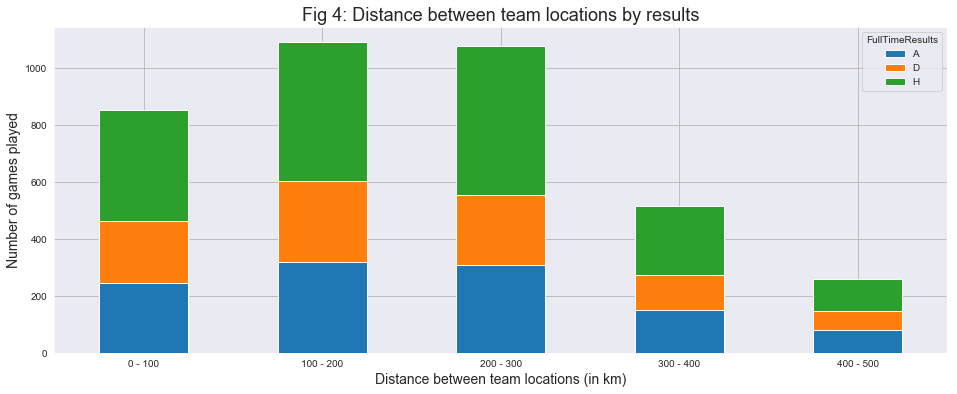

Percentage of home wins in bin 0 - 100 is 45.7%.
Percentage of home wins in bin 100 - 200 is 44.6%.
Percentage of home wins in bin 200 - 300 is 48.6%.
Percentage of home wins in bin 300 - 400 is 47.3%.
Percentage of home wins in bin 400 - 500 is 43.5%.


In [11]:
# create pivot table with index = bins of distance between home and away team locations
dist_df = df_cd.copy()
dist_df['Distance between H and A (in km)'] = pd.cut(dist_df['Distance between H and A (in km)'], bins=5)
dist_agg = dist_df.groupby(['Distance between H and A (in km)', 'FullTimeResults']).size().reset_index(name="No. of teams")
dist_pivot = pd.pivot_table(dist_agg, index=['Distance between H and A (in km)'], columns=['FullTimeResults'],
                                        values='No. of teams', aggfunc=np.sum)
dist_pivot = dist_pivot.reset_index()

# plot stacked bar chart
fig, ax1 = plt.subplots()
dist_pivot.plot(kind='bar', stacked=True, figsize=DIMS, ax=ax1)
ax1.set_ylabel("Number of games played", fontsize = 14)
ax1.set_xlabel("Distance between team locations (in km)", fontsize = 14)
ax1.set_title("Fig 4: Distance between team locations by results", fontsize = 18)
plt.xticks(np.arange(5), ('0 - 100','100 - 200','200 - 300','300 - 400','400 - 500'), rotation = 0)
plt.show()

# find percentage of home wins in each bin
dist_dict = dist_pivot.to_dict()
wins_total = 0
def percent_total(DF,A,D,H,N):
    total = DF[A][N] + DF[D][N] + DF[H][N]
    return (str(round(DF[H][N]/total*100,1)) + "%")

# what is the win rate of home teams in each bin?
counter = 0
while (counter <= 4):
    for j in ['0 - 100','100 - 200','200 - 300','300 - 400','400 - 500']:
        print ("Percentage of home wins in bin " + j + " is " + percent_total(dist_dict,'A','D','H', counter)+".")
        counter += 1


By the common understanding of Home Court Advantage, we will expect the win rate of home teams to have a direct relationship with the distance between the two teams. Meaning to say, as the distance between the teams increases, the win rate of the home team should increase as well. However, from the bar chart, we can see that the home win rate is relatively consistent across all 5 bins with an average of 46%. Hence, when comparing the distance between teams, home court advantage does not affect the win rate of the home team.

## Conclusion

Results from this analysis show that Home Court Advantage may just be a myth after all. The home team does not necessarily score more goals and the away team does not necessarily garner "special attention" from the match referees. Most importantly, the fatigue levels faced by the travelling team is found to be overstated. This may be due to the fact matches are played on a weekly basis, allowing most teams to have ample rest time. 

Instead, the outcome of the game can be determined by other factors - such as quality of the players, team chemistry, execution of strategy, fitness level and many more. Therefore, regardless of whether a team is playing at home or away, they should still try to give their all instead of relying on Home Court Advantage.


#### Done By: Loy Sing Shun 